In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# trip is between 2012-03-20 to 2012-03-30
engine = create_engine("sqlite:///hawaii.sqlite")


In [3]:
inspector=inspect(engine)
inspector.get_table_names()

['measurements', 'station']

In [4]:
#Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()


['measurements', 'station']

In [5]:
#add tables to orm class
Station = Base.classes.station
Measurements = Base.classes.measurements

In [6]:
#starting a session
session = Session(engine)

# Precipitation Analysis

In [7]:
#Finding what is the last day of data on the measurment table
last_date = session.query(func.max(Measurements.date)).first()
last_date

('2017-08-23')

In [8]:
#getting the date for one year ago
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
last_year

datetime.date(2016, 8, 23)

In [9]:
#getting the last 12 months data
perc_one_year = session.query(
    Measurements.date, Measurements.prcp).filter(
    Measurements.date> last_year
        ).order_by(Measurements.date).all()
perc_df=pd.DataFrame(perc_one_year)
perc_df.head()


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


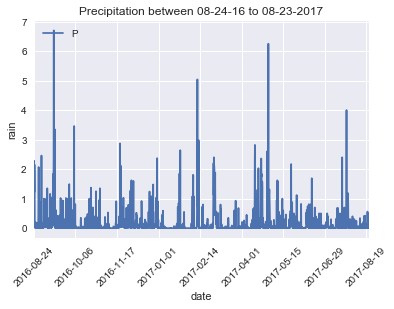

In [10]:
#plotting the data
perc_df.plot('date', 'prcp')
plt.xlabel('date')
plt.ylabel('rain')
plt.title('Precipitation between 08-24-16 to 08-23-2017')
plt.legend('Precipitation',loc='upper left')
plt.xticks(rotation=45)
plt.show()

# Station Analysis

In [11]:
#Total number of stations
total_stations = session.query(Station.station).count()
total_stations

9

In [12]:
#Most active station
station_active = session.query(
    Measurements.station, func.count(Measurements.date)
        ).group_by(Measurements.station).order_by(
        func.count(Measurements.date).desc()).all()


In [13]:
active_station=pd.DataFrame(station_active, columns=['station', 'tobs'])
active_station

,station,tobs
0,USC00519281,2772
1,USC00513117,2696
2,USC00519397,2685
3,USC00519523,2572
4,USC00516128,2484
5,USC00514830,1937
6,USC00511918,1932
7,USC00517948,683
8,USC00518838,342


In [14]:
print(
    'The most active station is {} with {} numner of observation'.format(
    station_active[0][0], station_active[0][1]))


The most active station is USC00519281 with 2772 numner of observation


In [15]:
most_active=station_active[0][0]
most_active

'USC00519281'

In [16]:
#Print the 
for station in range(total_stations):
    print ('Station {} had {} observatons.'.format (station_active[station][0], station_active[station][1]))

Station USC00519281 had 2772 observatons.
Station USC00513117 had 2696 observatons.
Station USC00519397 had 2685 observatons.
Station USC00519523 had 2572 observatons.
Station USC00516128 had 2484 observatons.
Station USC00514830 had 1937 observatons.
Station USC00511918 had 1932 observatons.
Station USC00517948 had 683 observatons.
Station USC00518838 had 342 observatons.


In [17]:
temperature_obs = session.query(
    Measurements.date, Measurements.tobs).filter(
    Measurements.station==most_active).filter(
    Measurements.date>last_year).order_by(
        Measurements.date).all()

In [18]:
temperature_obs[:5]

[('2016-08-24', 77),
 ('2016-08-25', 80),
 ('2016-08-26', 80),
 ('2016-08-27', 75),
 ('2016-08-28', 73)]

In [19]:
temperature_df=pd.DataFrame(temperature_obs)

In [20]:
temperature_df.head()

,date,tobs
0,2016-08-24,77
1,2016-08-25,80
2,2016-08-26,80
3,2016-08-27,75
4,2016-08-28,73


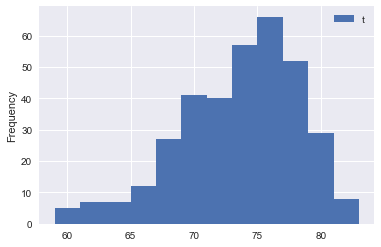

In [21]:
plt.hist(temperature_df['tobs'], bins=12)
plt.legend('tobs')
plt.ylabel('Frequency')
plt.show()


# Temperature Analysis

In [22]:
# function will get start and end date and returns minimum, maximum and average temperatures for that range of date
def calc_temp(start_date, end_date):
    return session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)
                        ).filter(Measurements.date.between(start_date, end_date)).all()

In [23]:
#testing the function
calc_temp('2017-01-01', '2017-03-01')    

[(59, 80, 69.53097345132744)]

In [24]:
# calculate the min/max/avg from one year before the trip range
start_trip = dt.date(2018,4,23)
end_trip = dt.date(2018,5,10)
one_year = dt.timedelta(days=365)
temp = calc_temp(start_trip-one_year , end_trip-one_year)
temp=temp[0]
temp

(58, 81, 73.94)

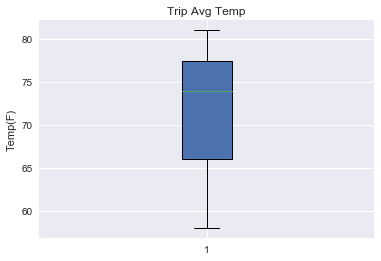

In [25]:
#box plot of the min/max/avg temperature of last year
fig, ax = plt.subplots()
x = range(len(temp))
ax.boxplot(temp, patch_artist=True)
ax.set_ylabel("Temp(F)")
ax.set_title("Trip Avg Temp")
plt.show()

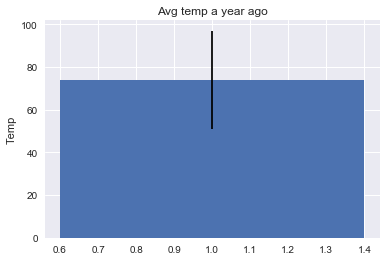

In [26]:
#Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
peak_to_peak = temp[1]-temp[0]
min_temp = temp[0]
max_temp = temp[1]
avg_temp = temp[2]
fig , ax = plt.subplots()
chart= ax.bar(1, avg_temp, yerr=peak_to_peak)
ax.set_ylabel("Temp")
ax.set_title("Avg temp a year ago")
plt.show()

# Optional Recommended Analysis

In [27]:
last_year_start=start_trip - one_year
last_year_end = end_trip - one_year
print('Start: ' + str(last_year_start) +',End: ' +str(last_year_end))

Start: 2017-04-23,End: 2017-05-10


In [28]:
trip_weather = session.query(
    Measurements.station,Measurements.date,Measurements.prcp,Measurements.tobs
).filter(Measurements.date >=last_year_start
).filter(Measurements.date<=last_year_end).order_by(Measurements.station).all()

In [29]:
trip_df=pd.DataFrame(trip_weather)